In [1]:
import os, sys
import datetime as dt
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from langchain_ollama.chat_models import ChatOllama

if 'api' in sys.modules:
    del sys.modules['api']
if 'plot' in sys.modules:
    del sys.modules['plot']
if 'util' in sys.modules:
    del sys.modules['util']
if 'recognition_evaluators' in sys.modules:
    del sys.modules['recognition_evaluators']

from recognition_evaluators import evaluate_tm_df, our_evaluator_true, our_evaluator_false, our_evaluator_top1, language_metrics
from util import dictcount
from api import TextMetrics
from plot import plot_bar_from_list_minmax


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Experiment with multi-class cognitive distorion detection

In [2]:
texts = [
    ("I think he thinks about me.", "Mind Reading"),
    ("It always happens every time over and over again", "Overgeneralization"),
    ("This is enourmously huge and terrific.", "Magnification"),
    ("I know it will be that way and I forecast it.", "Furtune-telling"),
    ("He is stupid, lazy and ignorant narciss.", "Labeling"),
    ("I am guilty and it is my failure.", "Personalization"),
    ("I am either excited and amazed or abused and upset.", "Emotional reasoning"), 
    ("I ruined the whole recital because of that one mistake.", "Mental filter"),
    ("I must do it, I should have that.", "Should statement"),
    ("A single mistake ruins the entire life. Either you love me or you hate me.", "All-or-nothing thinking")
]
dists = set([x[1] for x in texts])
dists

{'All-or-nothing thinking',
 'Emotional reasoning',
 'Furtune-telling',
 'Labeling',
 'Magnification',
 'Mental filter',
 'Mind Reading',
 'Overgeneralization',
 'Personalization',
 'Should statement'}

In [3]:
llm_llama32 = ChatOllama(model="llama3.2", base_url="http://localhost:11434", temperature=0.0)  # Explicitly set base_url
llm_qwen2 = ChatOllama(model="qwen2", base_url="http://localhost:11434", temperature=0.0)  # Explicitly set base_url
llm_qwen25_7 = ChatOllama(model="qwen2.5:7b", base_url="http://localhost:11434", temperature=0.0)


In [4]:
def evaluate_specific_model(model,text,dists,debug=False):
    query = f'You are professional psycho-therapist experienced in cognitive-behavioral therapy. '\
f'You can label texts witn none or some of cognitive distortoions, represented by the following labels: {str(dists)}. '\
f'When labeling, return only JSON array in square brackets of strings in double quotes representing the labels. '\
f'Label this text for presense or absence of any cognitive distortions fom given list: "{text}"'
    if debug:
        print(query)
    rep = model.invoke(query).content
    return rep


In [5]:
print(evaluate_specific_model(llm_llama32,"I think he thinks about me.",dists,True))
print(evaluate_specific_model(llm_qwen2,"I think he thinks about me.",dists,True))
print(evaluate_specific_model(llm_qwen25_7,"I think he thinks about me.",dists,True))


You are professional psycho-therapist experienced in cognitive-behavioral therapy. You can label texts witn none or some of cognitive distortoions, represented by the following labels: {'All-or-nothing thinking', 'Mental filter', 'Furtune-telling', 'Mind Reading', 'Personalization', 'Emotional reasoning', 'Should statement', 'Magnification', 'Labeling', 'Overgeneralization'}. When labeling, return only JSON array in square brackets of strings in double quotes representing the labels. Label this text for presense or absence of any cognitive distortions fom given list: "I think he thinks about me."
["Mind Reading"]
You are professional psycho-therapist experienced in cognitive-behavioral therapy. You can label texts witn none or some of cognitive distortoions, represented by the following labels: {'All-or-nothing thinking', 'Mental filter', 'Furtune-telling', 'Mind Reading', 'Personalization', 'Emotional reasoning', 'Should statement', 'Magnification', 'Labeling', 'Overgeneralization'}. 

In [6]:
for t in texts:
    print(f"{t[1]}: {t[0]}")
    rep = evaluate_specific_model(llm_llama32,t,dists,False)
    print(rep)
    rep_list = []
    for metric in dists:
        if metric in rep:
            rep_list.append(metric)
    print({value: 1.0 for index, value in enumerate(rep_list)})
    print()

Mind Reading: I think he thinks about me.
["Mind Reading"]
{'Mind Reading': 1.0}

Overgeneralization: It always happens every time over and over again
[["All-or-nothing thinking", "Overgeneralization"]]
{'All-or-nothing thinking': 1.0, 'Overgeneralization': 1.0}

Magnification: This is enourmously huge and terrific.
["Magnification"]
{'Magnification': 1.0}

Furtune-telling: I know it will be that way and I forecast it.
[["Furtune-telling"]]
{'Furtune-telling': 1.0}

Labeling: He is stupid, lazy and ignorant narciss.
["Labeling"]
{'Labeling': 1.0}

Personalization: I am guilty and it is my failure.
[None]
{}

Emotional reasoning: I am either excited and amazed or abused and upset.
["All-or-nothing thinking", "Emotional reasoning"]
{'All-or-nothing thinking': 1.0, 'Emotional reasoning': 1.0}

Mental filter: I ruined the whole recital because of that one mistake.
["All-or-nothing thinking", "Emotional reasoning"]
{'All-or-nothing thinking': 1.0, 'Emotional reasoning': 1.0}

Should stateme

In [7]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"


Path to dataset files: C:\Users\anton\.cache\kagglehub\datasets\sagarikashreevastava\cognitive-distortion-detetction-dataset\versions\1


## Explore accuracy for primary distortion in Multi-class dataset


In [8]:
df = pd.read_csv(multiclass_dataset_file_path) 
df = df.drop('Id_Number', axis=1) # delete columnb with id 
df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [9]:
all_dists = {}
for _, row in df.iterrows():
    # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
    text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
    primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
    secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
    dictcount(all_dists,primary_distortion)
    if not secondary_distortion is None:
        dictcount(all_dists,secondary_distortion)
print(all_dists)
del all_dists['No Distortion']
all_dists

{'Personalization': 202, 'Labeling': 203, 'Emotional Reasoning': 169, 'No Distortion': 933, 'Fortune-telling': 210, 'Magnification': 245, 'Mind Reading': 295, 'All-or-nothing thinking': 126, 'Overgeneralization': 277, 'Mental filter': 151, 'Should statements': 135}


{'Personalization': 202,
 'Labeling': 203,
 'Emotional Reasoning': 169,
 'Fortune-telling': 210,
 'Magnification': 245,
 'Mind Reading': 295,
 'All-or-nothing thinking': 126,
 'Overgeneralization': 277,
 'Mental filter': 151,
 'Should statements': 135}

In [10]:
split_shifts = [0,1,2]
validation_fraction = 5


In [11]:
def llm_evaluator_top1(all_metrics,model,text,threshold,top=1):
    rep = evaluate_specific_model(model,text,dists=all_metrics,debug=False)
    #print(text)
    #print(rep)
    rep_list = []
    for metric in all_metrics:
        if metric in rep:
            rep_list.append(metric)
    dic = {value: 1.0 for index, value in enumerate(rep_list[:top])}
    #print(dic)
    return dic

def llm_evaluator_top10(all_metrics,model,text,threshold,top=10):
    rep = evaluate_specific_model(model,text,dists=all_metrics,debug=False)
    #print(text)
    #print(rep)
    rep_list = []
    for metric in all_metrics:
        if metric in rep:
            rep_list.append(metric)
    dic = {value: 1.0 for index, value in enumerate(rep_list[:top])}
    #print(dic)
    return dic

In [12]:
all_eval_results = {}

In [13]:
eval_results = []
for split_shift in split_shifts:
    test_df  = df[(df.index + split_shift) % validation_fraction == 0]
    eval_result = evaluate_tm_df(test_df,None,our_evaluator_true,None,all_metrics=all_dists,encode_spaces=False,debug=False)
    eval_results.append(eval_result)

for eval_result in eval_results:
    print(eval_result[2]) # F1

all_eval_results['Const(True)'] = eval_results


{'Personalization': 0.16, 'Labeling': 0.14990859232175505, 'Emotional Reasoning': 0.12939001848428835, 'Fortune-telling': 0.17328519855595667, 'Magnification': 0.18962432915921287, 'Mind Reading': 0.16998191681735988, 'All-or-nothing thinking': 0.09416195856873823, 'Overgeneralization': 0.20884955752212392, 'Mental filter': 0.11194029850746268, 'Should statements': 0.10131332082551595}
{'Personalization': 0.15328467153284672, 'Labeling': 0.17657657657657655, 'Emotional Reasoning': 0.09774436090225565, 'Fortune-telling': 0.16666666666666669, 'Magnification': 0.16998191681735988, 'Mind Reading': 0.21516754850088185, 'All-or-nothing thinking': 0.11895910780669143, 'Overgeneralization': 0.199288256227758, 'Mental filter': 0.10486891385767791, 'Should statements': 0.08333333333333333}
{'Personalization': 0.15328467153284672, 'Labeling': 0.12244897959183672, 'Emotional Reasoning': 0.11194029850746268, 'Fortune-telling': 0.12939001848428835, 'Magnification': 0.17328519855595667, 'Mind Reading

In [14]:
eval_results = []
for split_shift in split_shifts:
    test_df  = df[(df.index + split_shift) % validation_fraction == 0]
    eval_result = evaluate_tm_df(test_df,None,our_evaluator_false,None,all_metrics=all_dists,encode_spaces=False,debug=False)
    eval_results.append(eval_result)

for eval_result in eval_results:
    print(eval_result[2]) # F1

all_eval_results['Const(False)'] = eval_results

{'Personalization': 0, 'Labeling': 0, 'Emotional Reasoning': 0, 'Fortune-telling': 0, 'Magnification': 0, 'Mind Reading': 0, 'All-or-nothing thinking': 0, 'Overgeneralization': 0, 'Mental filter': 0, 'Should statements': 0}
{'Personalization': 0, 'Labeling': 0, 'Emotional Reasoning': 0, 'Fortune-telling': 0, 'Magnification': 0, 'Mind Reading': 0, 'All-or-nothing thinking': 0, 'Overgeneralization': 0, 'Mental filter': 0, 'Should statements': 0}
{'Personalization': 0, 'Labeling': 0, 'Emotional Reasoning': 0, 'Fortune-telling': 0, 'Magnification': 0, 'Mind Reading': 0, 'All-or-nothing thinking': 0, 'Overgeneralization': 0, 'Mental filter': 0, 'Should statements': 0}


In [15]:
all_metricsmap = {'All-or-nothing_thinking':'dichotomous-reasoning',
              'Fortune-telling':'fortune-telling',
              'Mental_filter':'mental-filtering',
              'Overgeneralization':'overgeneralizing',
              'Labeling':'labeling',
              'Mind_Reading':'mindreading',
              'Personalization':'personalizing',
              'Emotional_Reasoning':'emotional-reasoning',
              'Magnification':'magnification',
              'Should_statements':'should-statement'}

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + metrics_list[m] + '.txt'
    return metrics

tm_base = TextMetrics(language_metrics('',all_metricsmap,path='../../data/models/distortions/ours')
                  ,encoding="utf-8",metric_logarithmic=True,debug=False)

eval_results = []
for split_shift in split_shifts:
    #test_df  = df[(df.index + split_shift) % 1 == 0]
    test_df  = df[(df.index + split_shift) % validation_fraction == 0]
    eval_result = evaluate_tm_df(test_df,tm_base,our_evaluator_top1,0.4,all_metrics=all_dists,encode_spaces=False,debug=False)
    eval_results.append(eval_result)

for eval_result in eval_results:
    print(eval_result[2]) # F1

all_eval_results['arinicheva25'] = eval_results


{'Personalization': 0.31578947368421056, 'Labeling': 0.15384615384615383, 'Emotional Reasoning': 0, 'Fortune-telling': 0, 'Magnification': 0, 'Mind Reading': 0, 'All-or-nothing thinking': 0, 'Overgeneralization': 0.2222222222222222, 'Mental filter': 0, 'Should statements': 0}
{'Personalization': 0.5517241379310346, 'Labeling': 0.5, 'Emotional Reasoning': 0, 'Fortune-telling': 0, 'Magnification': 0.5, 'Mind Reading': 0, 'All-or-nothing thinking': 0, 'Overgeneralization': 0.7142857142857143, 'Mental filter': 0, 'Should statements': 0}
{'Personalization': 0.3636363636363637, 'Labeling': 0.5714285714285715, 'Emotional Reasoning': 0, 'Fortune-telling': 0, 'Magnification': 0, 'Mind Reading': 0, 'All-or-nothing thinking': 0, 'Overgeneralization': 0.4444444444444445, 'Mental filter': 0, 'Should statements': 0}


In [16]:
eval_results = []
for split_shift in split_shifts:
    test_df  = df[(df.index + split_shift) % validation_fraction == 0]
    eval_result = evaluate_tm_df(test_df,llm_llama32,llm_evaluator_top1,None,all_metrics=all_dists,encode_spaces=False,debug=False)
    eval_results.append(eval_result)

for eval_result in eval_results:
    print(eval_result[2]) # F1

all_eval_results['LLAMA 3.2'] = eval_results

{'Personalization': 0.15555555555555556, 'Labeling': 0.1875, 'Emotional Reasoning': 0.20689655172413793, 'Fortune-telling': 0, 'Magnification': 0, 'Mind Reading': 0, 'All-or-nothing thinking': 0.163265306122449, 'Overgeneralization': 0, 'Mental filter': 0, 'Should statements': 0.4}
{'Personalization': 0.14503816793893132, 'Labeling': 0.4444444444444445, 'Emotional Reasoning': 0.1553398058252427, 'Fortune-telling': 0, 'Magnification': 0, 'Mind Reading': 0, 'All-or-nothing thinking': 0.10256410256410257, 'Overgeneralization': 0, 'Mental filter': 0, 'Should statements': 0.5}
{'Personalization': 0.1561338289962825, 'Labeling': 0.2608695652173913, 'Emotional Reasoning': 0.3018867924528302, 'Fortune-telling': 0, 'Magnification': 0, 'Mind Reading': 0, 'All-or-nothing thinking': 0.22950819672131148, 'Overgeneralization': 0, 'Mental filter': 0, 'Should statements': 0.7692307692307693}


In [17]:
eval_results = []
for split_shift in split_shifts:
    test_df  = df[(df.index + split_shift) % validation_fraction == 0]
    eval_result = evaluate_tm_df(test_df,llm_qwen2,llm_evaluator_top1,None,all_metrics=all_dists,encode_spaces=False,debug=False)
    eval_results.append(eval_result)

for eval_result in eval_results:
    print(eval_result[2]) # F1

all_eval_results['QWEN 2'] = eval_results

{'Personalization': 0.5, 'Labeling': 0.18888888888888886, 'Emotional Reasoning': 0.2553191489361702, 'Fortune-telling': 0.4533333333333333, 'Magnification': 0, 'Mind Reading': 0, 'All-or-nothing thinking': 0, 'Overgeneralization': 0.13114754098360656, 'Mental filter': 0.6666666666666666, 'Should statements': 1.0}
{'Personalization': 0.5, 'Labeling': 0.21359223300970873, 'Emotional Reasoning': 0.2857142857142857, 'Fortune-telling': 0.3793103448275862, 'Magnification': 0, 'Mind Reading': 0, 'All-or-nothing thinking': 0, 'Overgeneralization': 0.1694915254237288, 'Mental filter': 0, 'Should statements': 0}
{'Personalization': 0.7058823529411764, 'Labeling': 0.1566579634464752, 'Emotional Reasoning': 0.2916666666666667, 'Fortune-telling': 0.2702702702702703, 'Magnification': 0, 'Mind Reading': 1.0, 'All-or-nothing thinking': 0.6666666666666666, 'Overgeneralization': 0.20689655172413793, 'Mental filter': 0, 'Should statements': 1.0}


In [18]:
eval_results = []
for split_shift in split_shifts:
    test_df  = df[(df.index + split_shift) % validation_fraction == 0]
    eval_result = evaluate_tm_df(test_df,llm_qwen25_7,llm_evaluator_top1,None,all_metrics=all_dists,encode_spaces=False,debug=False)
    eval_results.append(eval_result)

for eval_result in eval_results:
    print(eval_result[2]) # F1

all_eval_results['QWEN 2.5:7B'] = eval_results

{'Personalization': 0.5, 'Labeling': 0.22140221402214022, 'Emotional Reasoning': 0.3018867924528302, 'Fortune-telling': 0.5176470588235293, 'Magnification': 0, 'Mind Reading': 0.7499999999999999, 'All-or-nothing thinking': 0.3076923076923077, 'Overgeneralization': 0.3448275862068966, 'Mental filter': 0.3076923076923077, 'Should statements': 0.6666666666666666}
{'Personalization': 0.5925925925925926, 'Labeling': 0.25938566552901027, 'Emotional Reasoning': 0.29629629629629634, 'Fortune-telling': 0.6, 'Magnification': 0.6666666666666666, 'Mind Reading': 0.4444444444444445, 'All-or-nothing thinking': 0.2222222222222222, 'Overgeneralization': 0.2696629213483146, 'Mental filter': 0, 'Should statements': 0.6666666666666666}
{'Personalization': 0.625, 'Labeling': 0.1947565543071161, 'Emotional Reasoning': 0.3157894736842105, 'Fortune-telling': 0.3448275862068966, 'Magnification': 0, 'Mind Reading': 1.0, 'All-or-nothing thinking': 0.19999999999999998, 'Overgeneralization': 0.2380952380952381, '

In [19]:
all_metricsmap = {value: value.replace(' ','_') for index, value in enumerate(all_dists)}

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + metrics_list[m] + '.txt'
    return metrics

eval_results = []
for split_shift in split_shifts:
    test_df  = df[(df.index + split_shift) % validation_fraction == 0]
    tm_new = TextMetrics(language_metrics('',all_metricsmap,path=f'../../data/models/distortions/shreevastava2021/multiclass-{split_shift+1}-0'),
                         encoding="utf-8",metric_logarithmic=True,debug=False)
    eval_result = evaluate_tm_df(test_df,tm_new,our_evaluator_top1,0.5,all_metrics=all_dists,encode_spaces=False,debug=False)
    eval_results.append(eval_result)

for eval_result in eval_results:
    print(eval_result[2]) # F1

all_eval_results['ours25'] = eval_results


{'Personalization': 0.2535211267605634, 'Labeling': 0.24000000000000002, 'Emotional Reasoning': 0.33333333333333337, 'Fortune-telling': 0.5333333333333333, 'Magnification': 0.3023255813953488, 'Mind Reading': 0.2857142857142857, 'All-or-nothing thinking': 0.2857142857142857, 'Overgeneralization': 0.37254901960784315, 'Mental filter': 0.3571428571428571, 'Should statements': 0.3636363636363636}
{'Personalization': 0.20689655172413793, 'Labeling': 0.4210526315789474, 'Emotional Reasoning': 0.16666666666666669, 'Fortune-telling': 0.47058823529411764, 'Magnification': 0.1758241758241758, 'Mind Reading': 0.2751322751322751, 'All-or-nothing thinking': 0.5, 'Overgeneralization': 0.25742574257425743, 'Mental filter': 0, 'Should statements': 0.25}
{'Personalization': 0.28205128205128205, 'Labeling': 0.27906976744186046, 'Emotional Reasoning': 0.4, 'Fortune-telling': 0.5, 'Magnification': 0.32323232323232326, 'Mind Reading': 0.3283582089552239, 'All-or-nothing thinking': 0.25, 'Overgeneralizatio

In [20]:
all_metricsmap = {value: value.replace(' ','_') for index, value in enumerate(all_dists)}

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + metrics_list[m] + '.txt'
    return metrics

eval_results = []
for split_shift in split_shifts:
    test_df  = df[(df.index + split_shift) % validation_fraction == 0]
    tm_new = TextMetrics(language_metrics('',all_metricsmap,path=f'../../data/models/distortions/shreevastava2021/multiclass-{split_shift+1}-0'),
                         encoding="utf-8",metric_logarithmic=True,weighted=True,debug=False)
    eval_result = evaluate_tm_df(test_df,tm_new,our_evaluator_top1,0.5,all_metrics=all_dists,encode_spaces=False,debug=False)
    eval_results.append(eval_result)

for eval_result in eval_results:
    print(eval_result[2]) # F1

all_eval_results['ours25-weighted'] = eval_results


{'Personalization': 0.3846153846153846, 'Labeling': 0.28571428571428575, 'Emotional Reasoning': 0.5333333333333333, 'Fortune-telling': 0.6842105263157895, 'Magnification': 0.37037037037037035, 'Mind Reading': 0.32894736842105265, 'All-or-nothing thinking': 0.5, 'Overgeneralization': 0.47826086956521735, 'Mental filter': 0.2608695652173913, 'Should statements': 0.5555555555555556}
{'Personalization': 0.36363636363636365, 'Labeling': 0.4800000000000001, 'Emotional Reasoning': 0.11764705882352941, 'Fortune-telling': 0.5714285714285714, 'Magnification': 0.3461538461538462, 'Mind Reading': 0.5321100917431193, 'All-or-nothing thinking': 0.5, 'Overgeneralization': 0.46808510638297873, 'Mental filter': 0.21052631578947367, 'Should statements': 0.6666666666666666}
{'Personalization': 0.41025641025641024, 'Labeling': 0.3428571428571429, 'Emotional Reasoning': 0.6666666666666666, 'Fortune-telling': 0.631578947368421, 'Magnification': 0.37333333333333335, 'Mind Reading': 0.5084745762711864, 'All-o

In [27]:
def build_averages(results_3runs,labels):
    results = {}
    ranges = {}
    for model in results_3runs:
        runs = results_3runs[model]
        #print(runs)
        #keys = set(runs[0][2].keys()).union(runs[1][2].keys(), runs[2][2].keys()) # F1
        model_averages = {}
        model_ranges = {}
        for key in labels:
            vals = [runs[0][2][key],runs[1][2][key],runs[2][2][key]]
            average = sum(vals)/3
            model_averages[key] = round(average,2)
            model_ranges[key] = (round(min(vals),2),round(max(vals),2))
        results[model] = [model_averages[key] for key in labels]
        ranges[model] = [model_ranges[key] for key in labels]
    return results, ranges

labels = sorted(all_dists)
values, ranges = build_averages(all_eval_results,labels)
del values['Const(False)']
del ranges['Const(False)']
del values['ours25']
del ranges['ours25']

for m in values:
    print(values[m],m)
print()
for m in ranges:
    print(ranges[m],m)


[0.1, 0.11, 0.16, 0.15, 0.18, 0.11, 0.2, 0.2, 0.16, 0.1] Const(True)
[0.0, 0.0, 0.0, 0.41, 0.17, 0.0, 0.0, 0.46, 0.41, 0.0] arinicheva25
[0.17, 0.22, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.15, 0.56] LLAMA 3.2
[0.22, 0.28, 0.37, 0.19, 0.0, 0.22, 0.33, 0.17, 0.57, 0.67] QWEN 2
[0.24, 0.3, 0.49, 0.23, 0.22, 0.24, 0.73, 0.28, 0.57, 0.64] QWEN 2.5:7B
[0.52, 0.44, 0.63, 0.37, 0.36, 0.34, 0.46, 0.44, 0.39, 0.74] ours25-weighted

[(0.09, 0.12), (0.1, 0.13), (0.13, 0.17), (0.12, 0.18), (0.17, 0.19), (0.1, 0.11), (0.17, 0.22), (0.2, 0.21), (0.15, 0.16), (0.08, 0.12)] Const(True)
[(0, 0), (0, 0), (0, 0), (0.15, 0.57), (0, 0.5), (0, 0), (0, 0), (0.22, 0.71), (0.32, 0.55), (0, 0)] arinicheva25
[(0.1, 0.23), (0.16, 0.3), (0, 0), (0.19, 0.44), (0, 0), (0, 0), (0, 0), (0, 0), (0.15, 0.16), (0.4, 0.77)] LLAMA 3.2
[(0, 0.67), (0.26, 0.29), (0.27, 0.45), (0.16, 0.21), (0, 0), (0, 0.67), (0, 1.0), (0.13, 0.21), (0.5, 0.71), (0, 1.0)] QWEN 2
[(0.2, 0.31), (0.3, 0.32), (0.34, 0.6), (0.19, 0.26), (0, 0.67), (0, 0.4

In [28]:
# Enter baseline F1 performance from the paper (Babacan, O˘guz, and Beyito˘glu 2025)
# https://dergipark.org.tr/tr/download/article-file/3865878, page 7
base_babacan = {'Mind Reading': 0.6415,
'Should statements': 0.4615,
'All-or-nothing thinking': 0.2041,
'Overgeneralization': 0.4928,
'Mental filter': 0.0000,
'Magnification': 0.0000,
'Emotional Reasoning': 0.1250,
'Personalization': 0.3913,
'Fortune-telling': 0.4348,
'Labeling': 0.5000}

values['babacan25'] = [round(base_babacan[label],2) for label in labels]
ranges['babacan25'] = [(values['babacan25'],values['babacan25']) for label in labels]

[0.1, 0.11, 0.16, 0.15, 0.18, 0.11, 0.2, 0.2, 0.16, 0.1] Const(True)
[0.0, 0.0, 0.0, 0.41, 0.17, 0.0, 0.0, 0.46, 0.41, 0.0] arinicheva25
[0.17, 0.22, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.15, 0.56] LLAMA 3.2
[0.22, 0.28, 0.37, 0.19, 0.0, 0.22, 0.33, 0.17, 0.57, 0.67] QWEN 2
[0.24, 0.3, 0.49, 0.23, 0.22, 0.24, 0.73, 0.28, 0.57, 0.64] QWEN 2.5:7B
[0.52, 0.44, 0.63, 0.37, 0.36, 0.34, 0.46, 0.44, 0.39, 0.74] ours25-weighted
[0.2, 0.12, 0.43, 0.5, 0.0, 0.0, 0.64, 0.49, 0.39, 0.46] babacan25


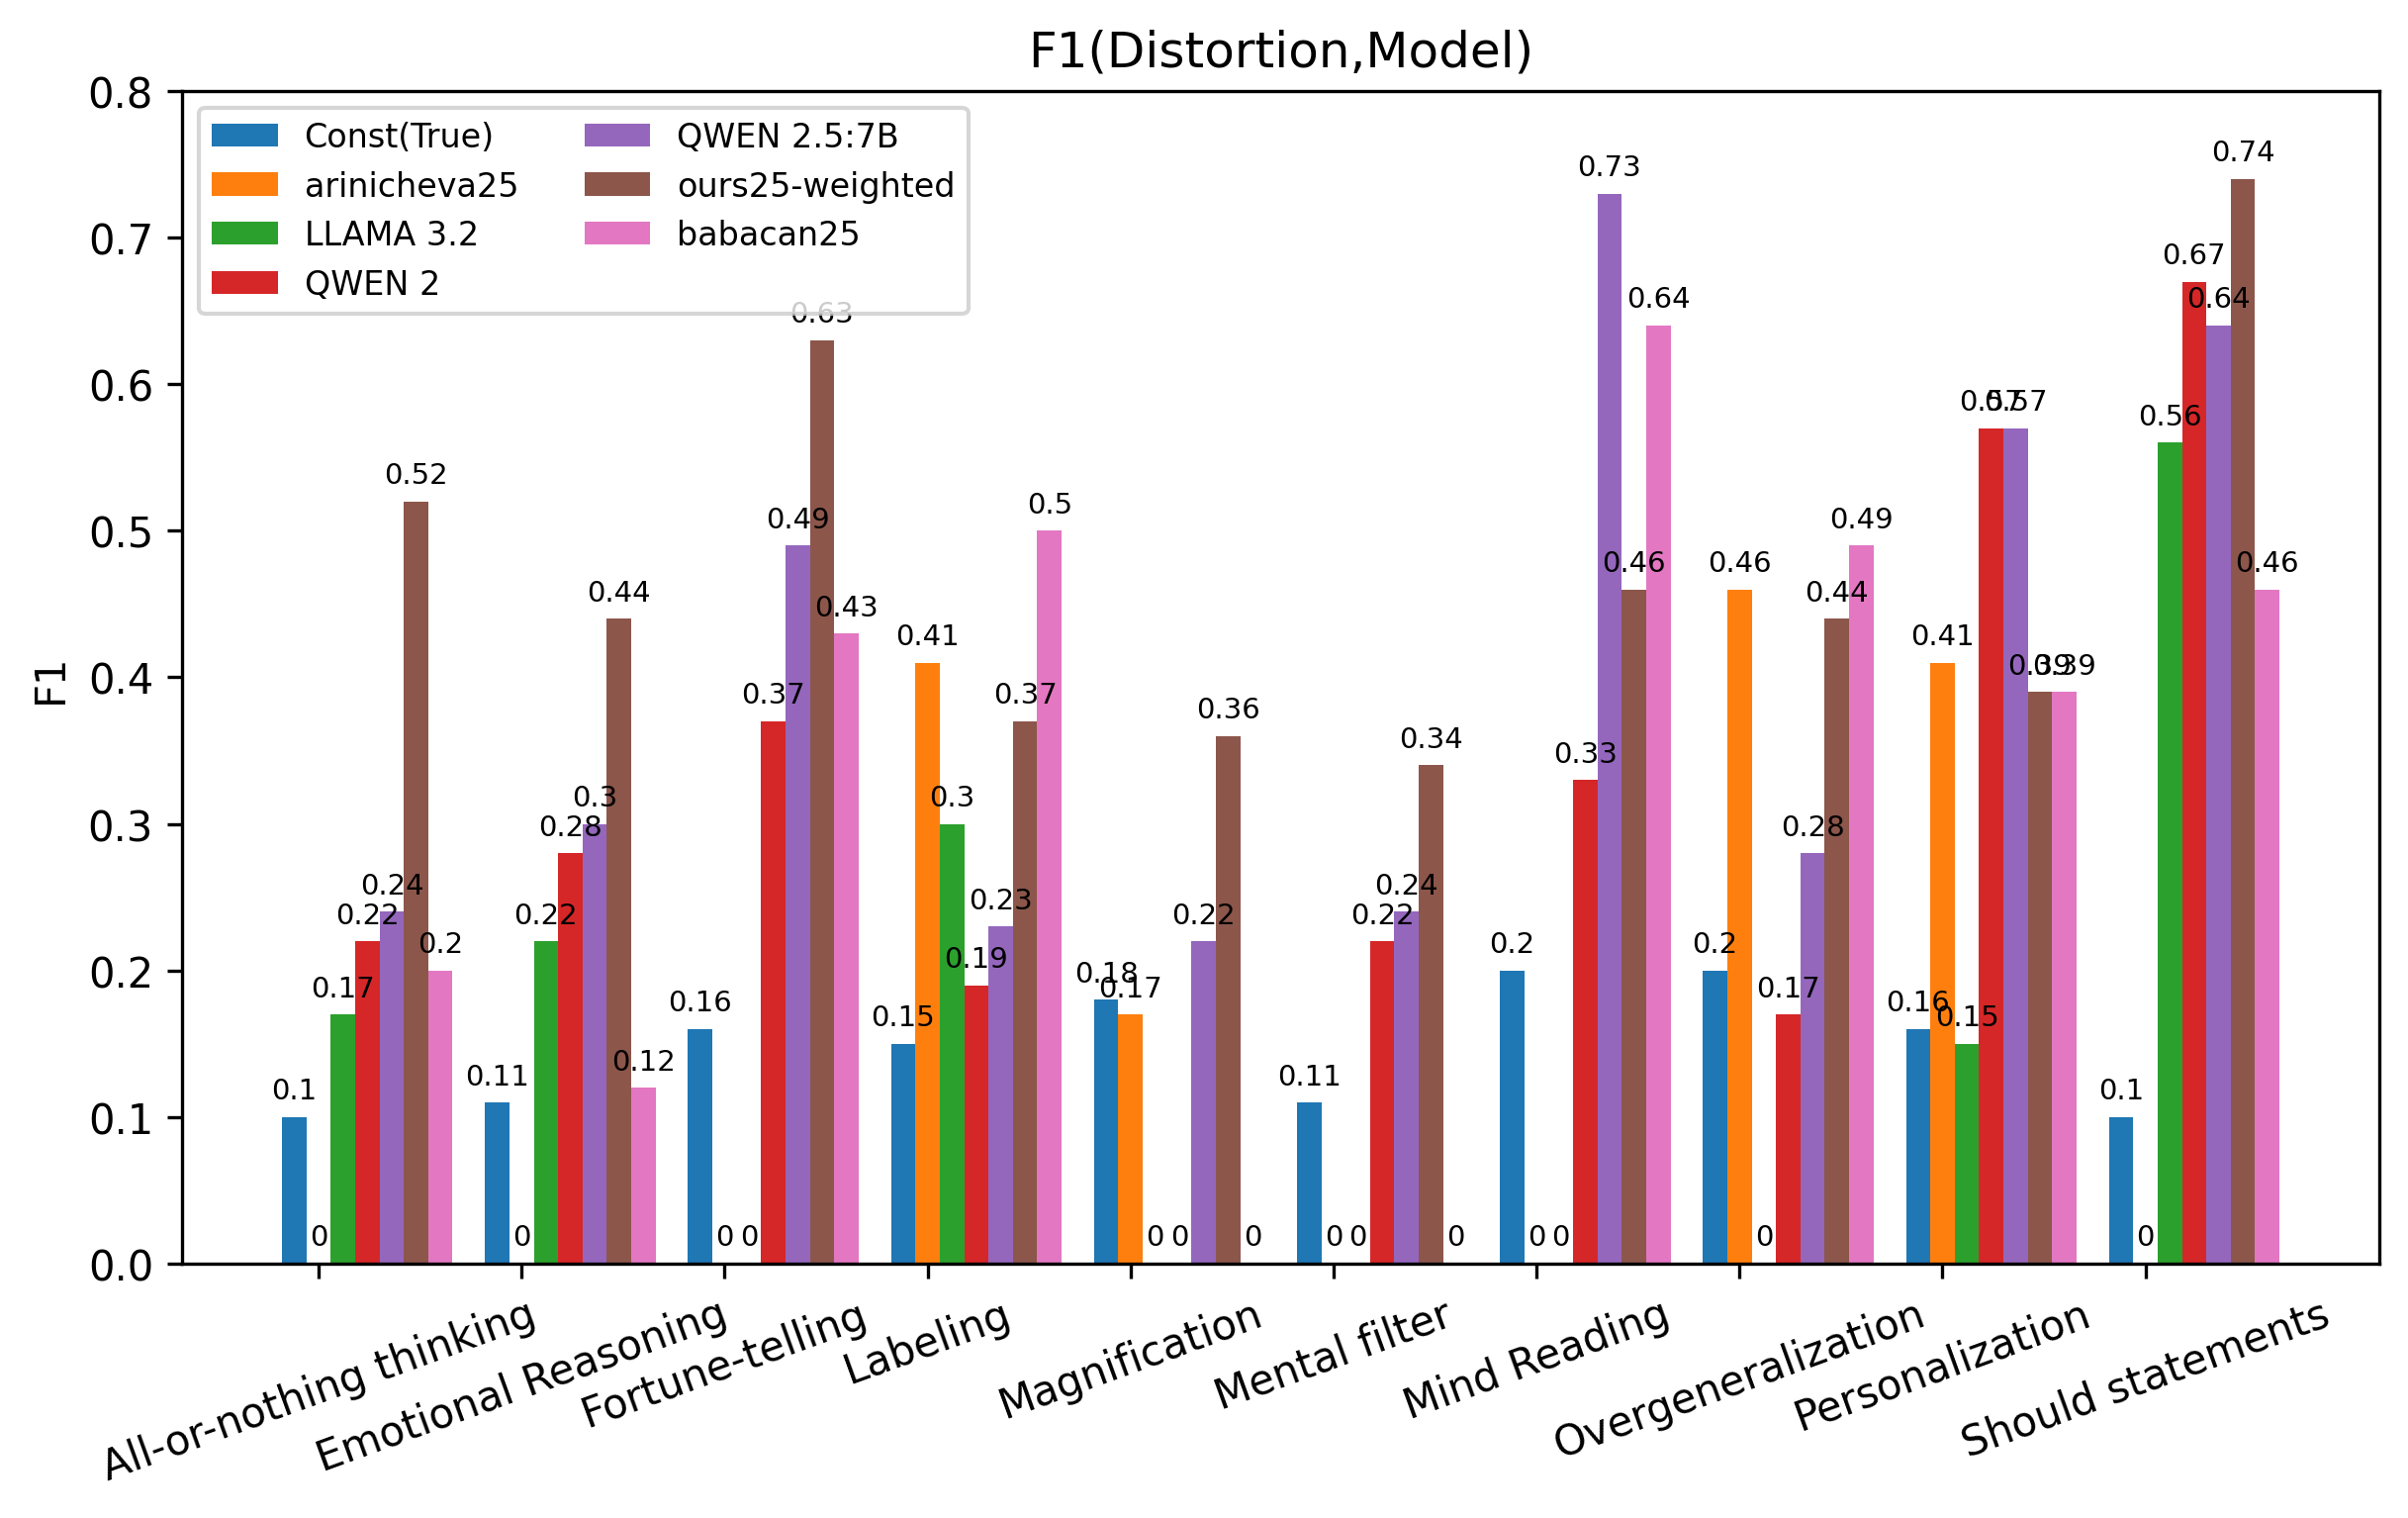

In [29]:
plt.rcParams["figure.figsize"] = (8,5)

x = np.arange(len(labels))  # the label locations
width = 0.12  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',dpi=300)

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    print(measurement, attribute)
    ax.bar_label(rects, padding=3, fontsize=7)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1')
ax.set_title('F1(Distortion,Model)')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=2, fontsize=8)
ax.set_ylim(0, 0.8)
ax.tick_params(axis='x', rotation=20)
fig.set_dpi(300)

plt.show()

[0.1, 0.11, 0.16, 0.15, 0.18, 0.11, 0.2, 0.2, 0.16, 0.1] Const(True)
[0.0, 0.0, 0.0, 0.41, 0.17, 0.0, 0.0, 0.46, 0.41, 0.0] arinicheva25
[0.17, 0.22, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.15, 0.56] LLAMA 3.2
[0.22, 0.28, 0.37, 0.19, 0.0, 0.22, 0.33, 0.17, 0.57, 0.67] QWEN 2
[0.24, 0.3, 0.49, 0.23, 0.22, 0.24, 0.73, 0.28, 0.57, 0.64] QWEN 2.5:7B
[0.52, 0.44, 0.63, 0.37, 0.36, 0.34, 0.46, 0.44, 0.39, 0.74] ours25-weighted
[0.2, 0.12, 0.43, 0.5, 0.0, 0.0, 0.64, 0.49, 0.39, 0.46] babacan25


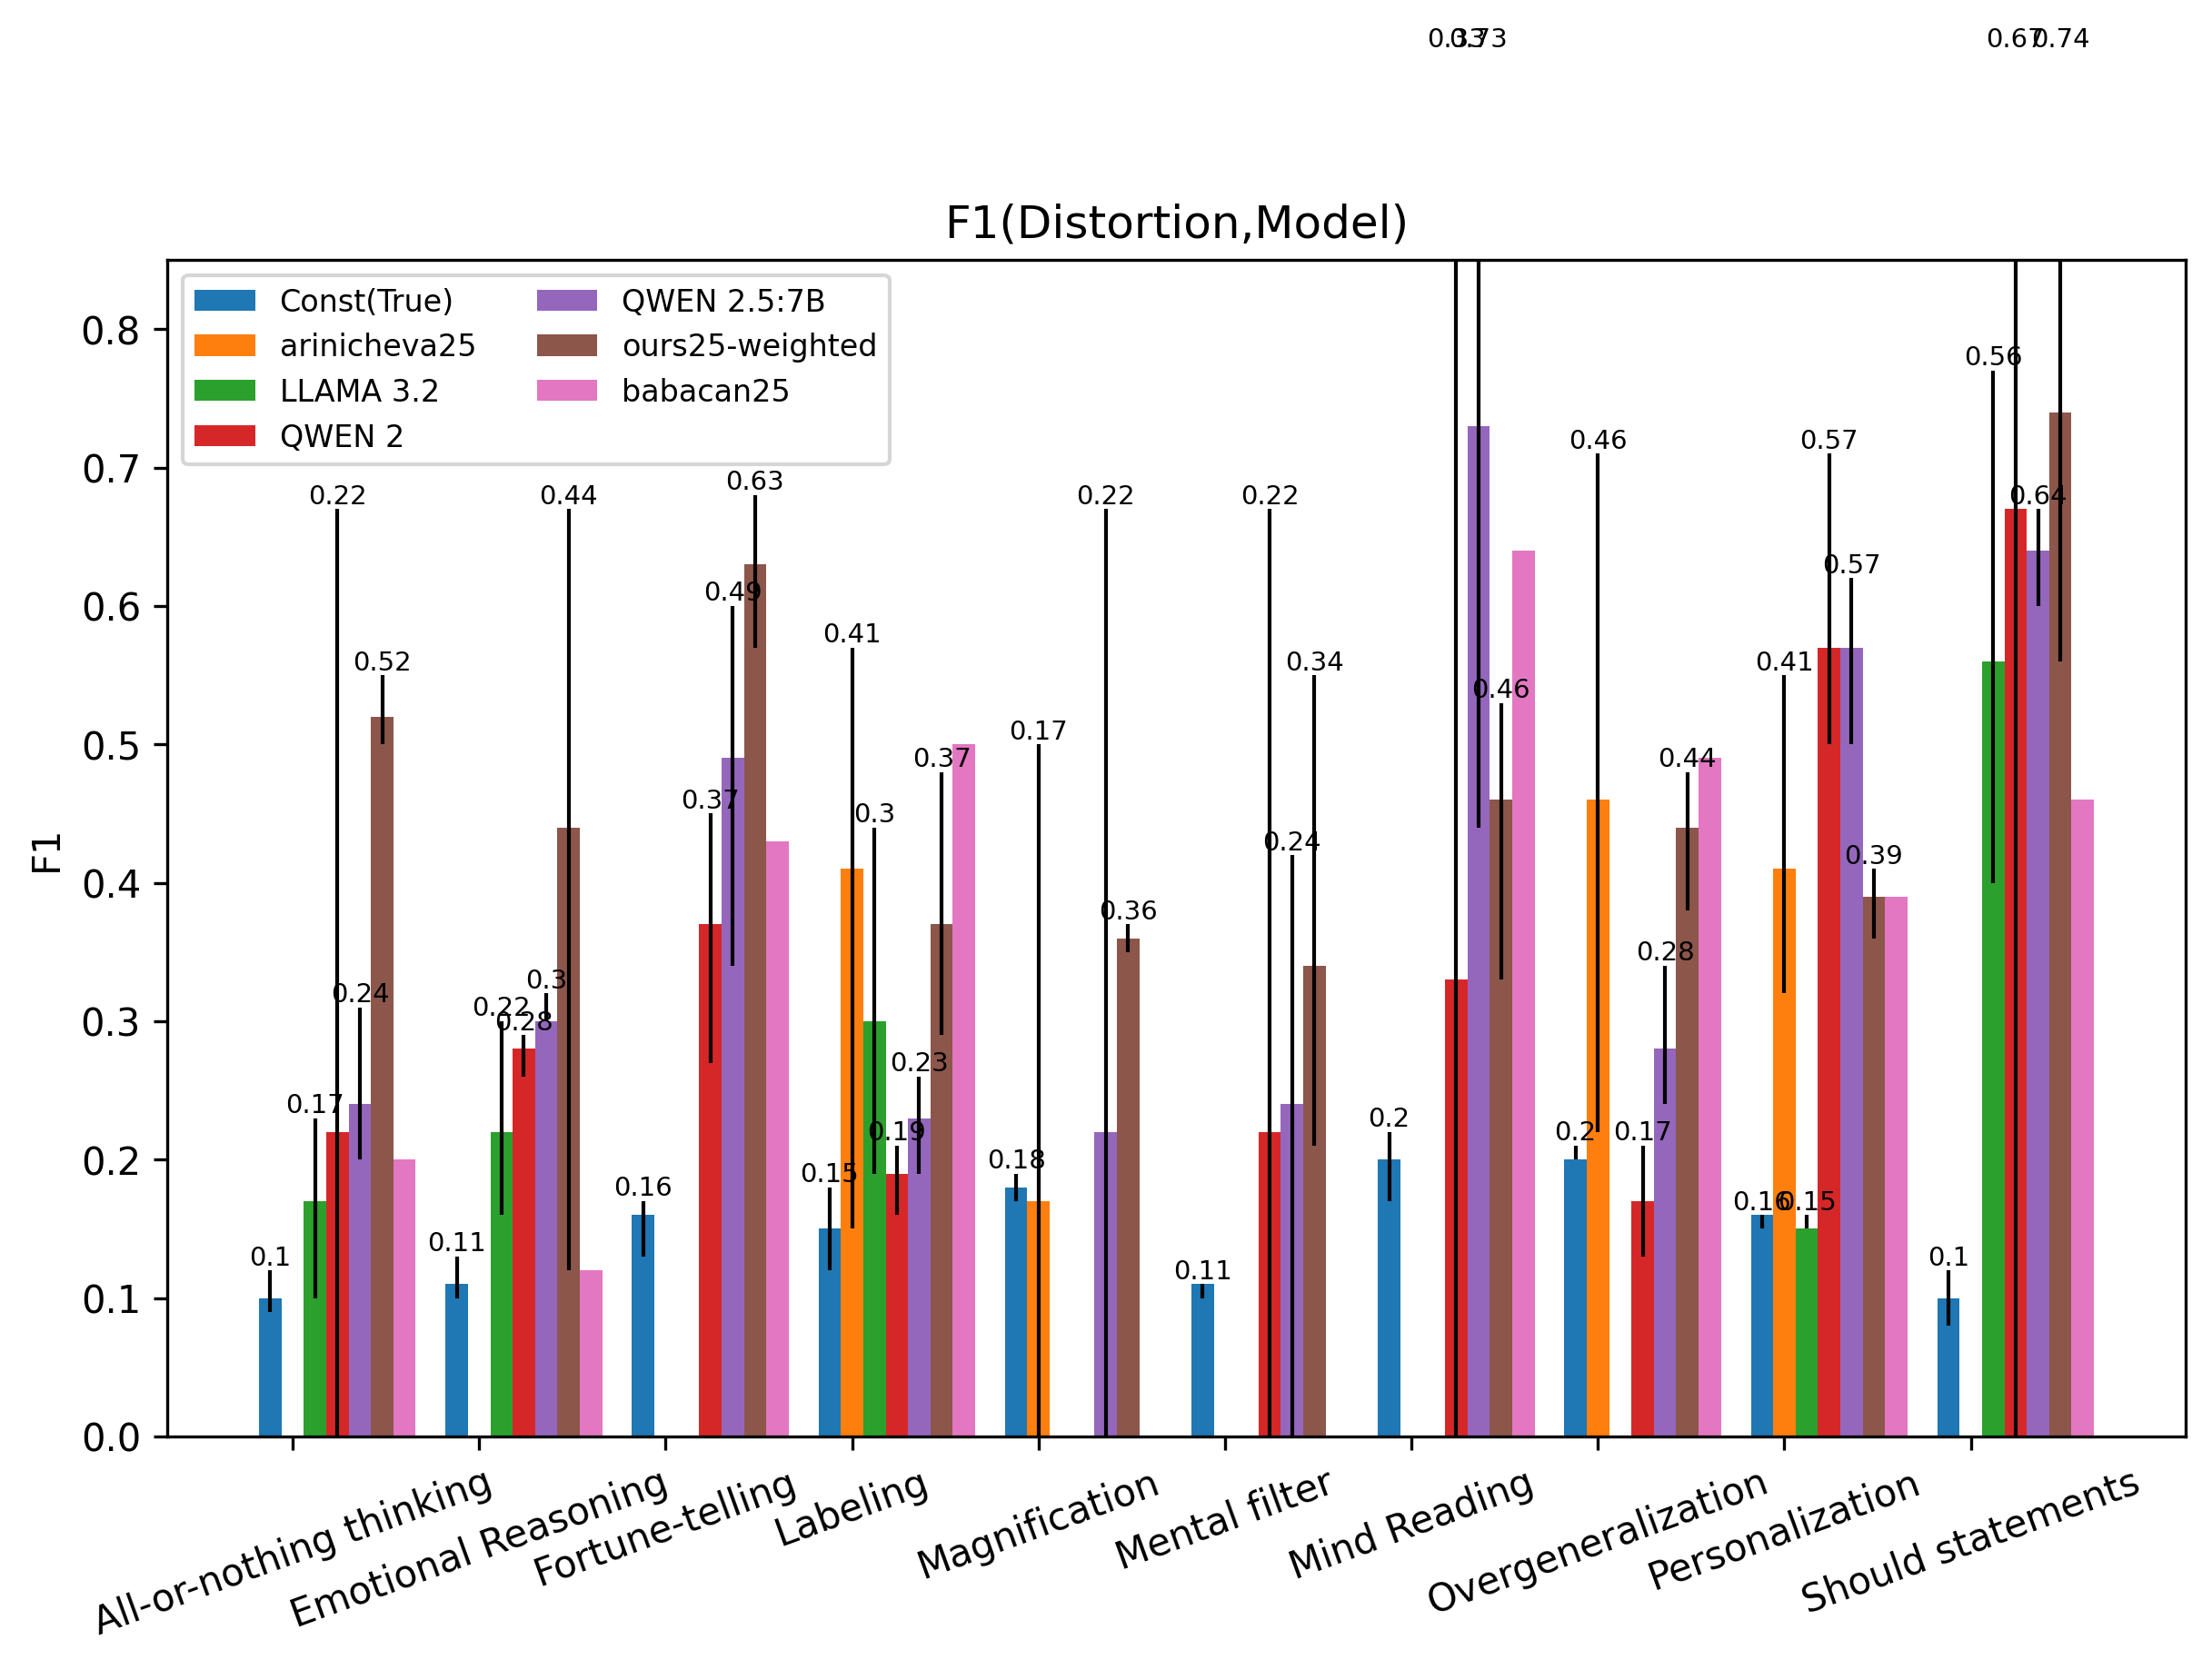

In [30]:
plt.rcParams["figure.figsize"] = (8,6)

x = np.arange(len(labels))  # the label locations
width = 0.12  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',dpi=300)


for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    print(measurement, attribute)
    #ax.bar_label(rects, padding=3, fontsize=7)
    multiplier += 1

all_values = []
all_ranges = []
for m in values:
    for i in range(len(labels)):
        all_values.append(values[m][i])
        all_ranges.append(ranges[m][i])
for p,mm,v in zip(ax.patches,all_ranges,all_values):
            xe = p.get_x()  # get the bottom left x corner of the bar
            w = p.get_width()  # get width of bar
            h = p.get_height()  # get height of bar
            min_y = mm[0]
            max_y = mm[1]
            if min_y < max_y:
                plt.vlines(xe+w/2, min_y, max_y, color='k', linewidth=1)  # draw a vertical line
                plt.text(xe+w/2,max_y,str(round(v,2)),horizontalalignment='center',verticalalignment='bottom', fontsize=7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1')
ax.set_title('F1(Distortion,Model)')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=2, fontsize=8)
ax.set_ylim(0, 0.85)
ax.tick_params(axis='x', rotation=20)
fig.set_dpi(300)

plt.show()

In [31]:
avgs = []
minmaxs = []
models = list(values)
for m in values:
    vals = values[m]
    avg = round(sum(vals)/len(vals),2)
    minv = min(vals)
    maxv = max(vals)
    avgs.append(avg)
    minmaxs.append((minv,maxv))
    print(avg, m)

0.15 Const(True)
0.14 arinicheva25
0.14 LLAMA 3.2
0.3 QWEN 2
0.39 QWEN 2.5:7B
0.47 ours25-weighted
0.32 babacan25


['All-or-nothing thinking', 'Emotional Reasoning', 'Fortune-telling', 'Labeling', 'Magnification', 'Mental filter', 'Mind Reading', 'Overgeneralization', 'Personalization', 'Should statements']
[0.15, 0.14, 0.14, 0.3, 0.39, 0.47, 0.32]
[(0.1, 0.2), (0.0, 0.46), (0.0, 0.56), (0.0, 0.67), (0.22, 0.73), (0.34, 0.74), (0.0, 0.64)]


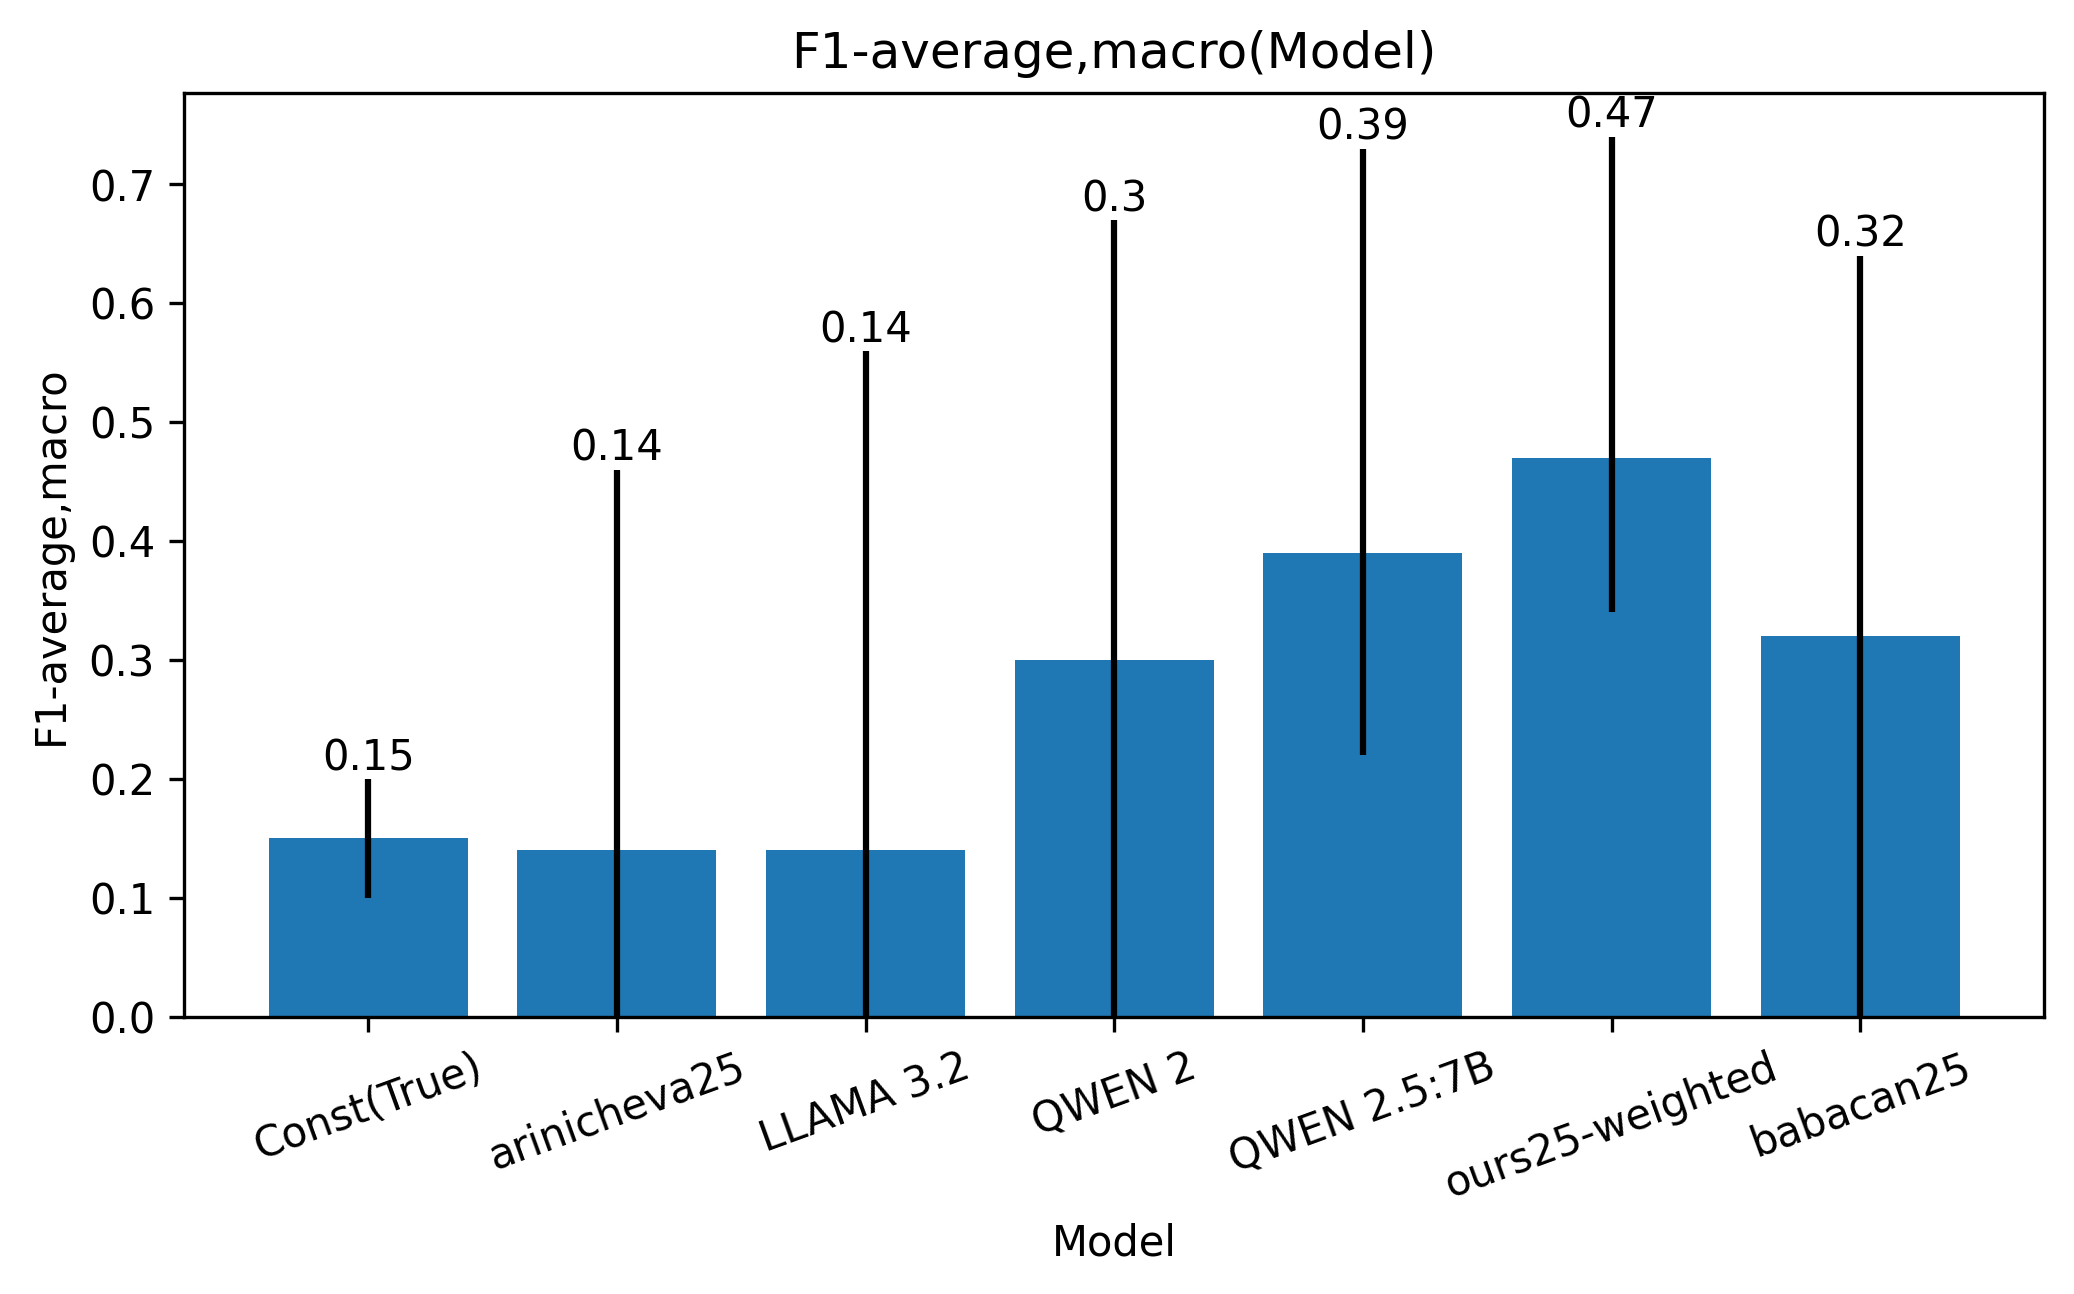

In [32]:
def plot_bar_from_list_minmax(label,labels,value,values,title=None,fontsize=None,minmax=None,dpi=300,x_rotation=0):
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.bar(labels, values)
    plt.title(f'{value}({label})' if title is None else title)
    plt.xlabel(label)
    plt.ylabel(value)
    if x_rotation != 0:
        ax.tick_params(axis='x', rotation=x_rotation)
    if not minmax is None:
        for p,mm,v in zip(ax.patches,minmax,values):
            x = p.get_x()  # get the bottom left x corner of the bar
            w = p.get_width()  # get width of bar
            h = p.get_height()  # get height of bar
            min_y = mm[0]
            max_y = mm[1]
            plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line
            plt.text(x+w/2,max_y,str(round(v,2)),horizontalalignment='center',verticalalignment='bottom')
    fig.set_dpi(dpi)
    plt.show()


print(labels)
print(avgs)
print(minmaxs)
plot_bar_from_list_minmax('Model',models,'F1-average,macro',avgs,minmax=minmaxs,x_rotation=20)
